In [92]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [87]:
#Read NN and BMS data
n=4;runid=0;function='tanh' #tanh, leaky_ReLU
realization=0
sigma=0.16
NPAR=10 #10, 20
steps=50000


#Read NN data
train_size=60
if sigma==0.1:
    file_model='NN_no_overfit_' + function + '_sigma_0.10_r_' + str(realization) + '.csv'
else:
    file_model='NN_no_overfit_' + function + '_sigma_' + str(sigma) + '_r_' + str(realization) + '.csv'

model_d='../data/trained_nns/' + file_model
d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)
display(dn)

#Read BMS trace
if sigma==0.1:
        filename='BMS_'+function+'_n_'+str(n)+'_sigma_0.10_r_' + str(realization) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
else:
        filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'


trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])

,x1,y,rep,noise,y_noise,ymodel
0,-1.95,2.583192e-05,4.0,0.395264,0.395290,0.376544
1,-1.90,1.331381e-05,4.0,-0.042380,-0.042367,0.009087
2,-1.85,4.632686e-06,4.0,-0.029841,-0.029837,-0.054067
3,-1.80,9.658734e-08,4.0,0.070141,0.070141,0.038584
4,-1.75,0.000000e+00,4.0,0.211918,0.211918,0.150109
...,...,...,...,...,...,...
75,1.80,9.936903e-01,4.0,0.201567,1.195257,1.023442
76,1.85,9.945467e-01,4.0,0.144854,1.139401,1.023760
77,1.90,9.952977e-01,4.0,0.204212,1.199509,1.024006
78,1.95,9.959525e-01,4.0,0.048691,1.044643,1.024189


In [88]:
#Parameters to read models
VARS = ['x1',]
x = dn[[c for c in VARS]].copy()


if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

In [89]:
#Minimum description length model
y=dn.y_noise

minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

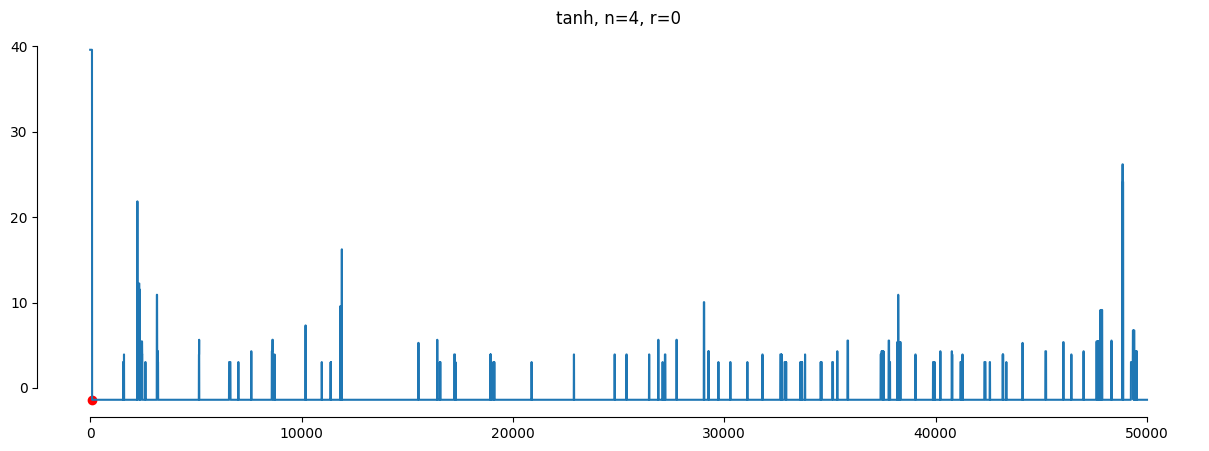

In [90]:
Nini = 00
plt.figure(figsize=(15, 5))

#Define figure size in cm                                                                           
Extensions=['.png']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                           
plt.title(str(function) + ', ' + 'n=' + str(n) +', r=' + str(realization))
plt.plot(trace.t[trace.t > Nini], trace.H[trace.t > Nini])
plt.scatter(minrow['t'], minH,color='r')
sns.despine(trim=True)

Name_figure='Energy_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

for ext in Extensions:
        plt.savefig('../results/' + Name_figure + ext,dpi=300)

 
plt.show()

0.499999999999984
60
0.9999999999999822


,x1,y,rep,noise,y_noise,ymodel,ybms
59,1.00,0.965519,4.0,-0.058945,0.906574,0.993227,1.000000
60,1.05,0.967961,4.0,-0.033672,0.934288,0.997785,1.022179
61,1.10,0.970311,4.0,-0.309686,0.660625,1.001763,1.046486
62,1.15,0.972572,4.0,-0.215512,0.757060,1.005226,1.072997
63,1.20,0.974748,4.0,-0.088512,0.886235,1.008233,1.101802
64,1.25,0.976842,4.0,0.219104,1.195947,1.010836,1.133003
65,1.30,0.978858,4.0,0.101862,1.080720,1.013084,1.166712
66,1.35,0.980794,4.0,0.101784,1.082578,1.015021,1.203054
67,1.40,0.982647,4.0,0.211197,1.193844,1.016684,1.242169
68,1.45,0.984411,4.0,-0.022429,0.961982,1.018108,1.284209


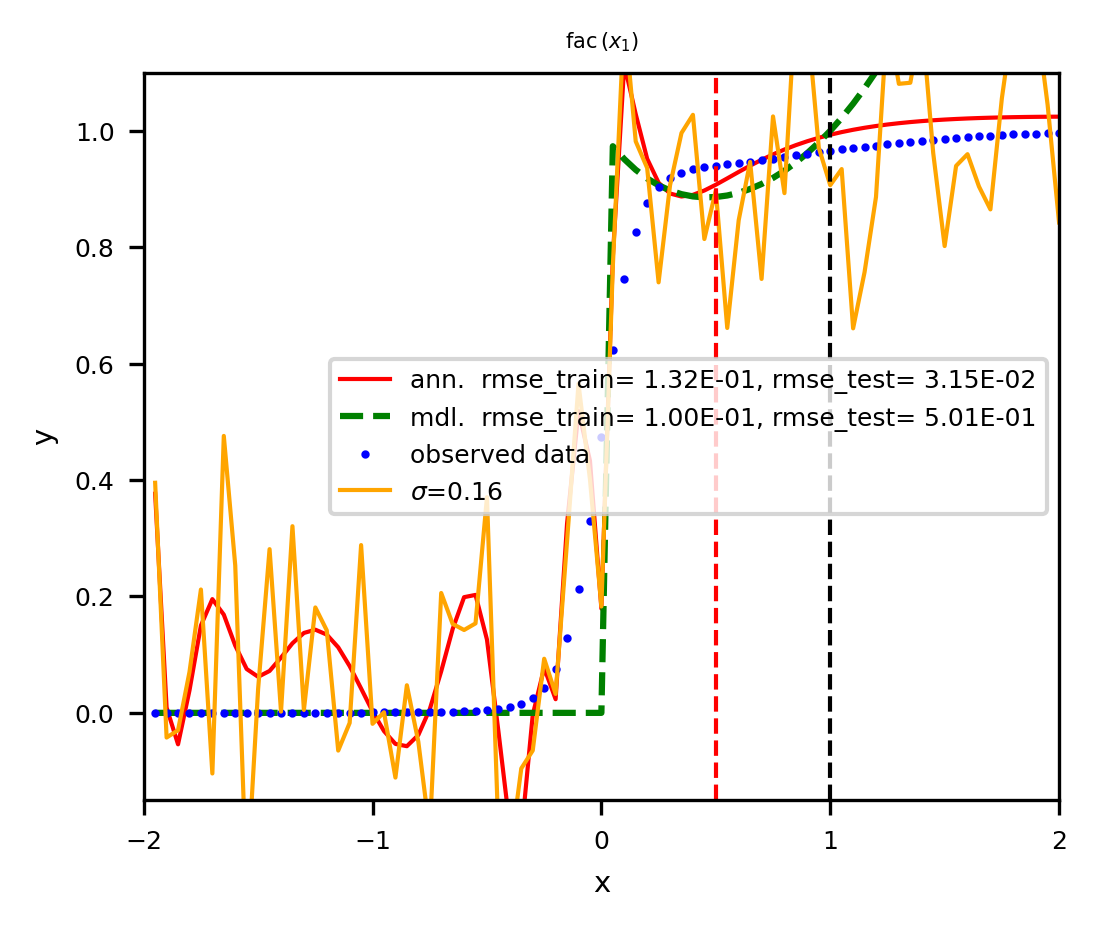

In [91]:
#Plot
train_size_ann=50
validation_border=dn.loc[train_size_ann-1]['x1']
print(validation_border)

train_border=dn.loc[train_size-1]['x1']
print(train_size)
print(train_border)

dplot = deepcopy(dn)
dplot['ybms'] = t.predict(x)

#display(dplot.loc[train_size-1:])
display(dplot.loc[train_size-1:])

rmse_nn_train=root_mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
rmse_nn_test=root_mean_squared_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])

#rmse_mdl=root_mean_squared_error(dplot.ybms,dn.y)
#display(dplot.loc[train_size-1:]['ybms'])
#display(dn.loc[train_size-1:]['y'])
rmse_mdl_train=root_mean_squared_error(dplot.loc[:train_size-1]['ybms'],dn.loc[:train_size-1]['y'])
rmse_mdl_test =root_mean_squared_error(dplot.loc[train_size-1:]['ybms'],dn.loc[train_size-1:]['y'])

 
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          


fig=figure(figsize=(width,height), dpi=300)                                                        

plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_nn_train, rmse_nn_test)) 

plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='mdl.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_mdl_train, rmse_mdl_test)) 

plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed data') 
#plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label='noise, ' + r'$\sigma$=' + str(sigma) ) 

plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label=r'$\sigma$=' + str(sigma) ) 
                                                                                

plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

plt.title('$%s$' % t.latex(),fontsize=size_title)
#plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

#plt.xlim(-4.5,4.5);plt.ylim(-1.1,1.5) 
plt.xlim(-2,2);plt.ylim(-0.15,1.1)  

Name_figure='Prediction_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()